Thie notebook examines the NOAA tidal predictions at Neah Bay.

Question:
1. Is NOAA using the long period constituents in its tidal predictions?

To approach this questions, I used t_tide to generate two tidal predictions: one with long period constituents and one without. I used a year in which I had a similar amplitude for Sa as what is published on the NOAA Neah Bay site (~12cm).

I also downloaded the NOAA published tidal predictions and the NOAA observations from Jan 2015 - Sept 2015.

The tidal predictions I generated are from Jan 2015-Dec 2015.

I would like to see if the NOAA produced tidal predictions match well with one of the tidal predictions that I produced.

In [1]:
import pandas as pd
from salishsea_tools.nowcast import figures
from salishsea_tools import stormtools
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Load tidal predictions with long period excluded

In [2]:
filename = 'NeahBay_tidal_prediction_31-Dec-2014_31-Dec-2015_nolong.csv'
tide_nolong, msl = stormtools.load_tidal_predictions(filename)

Load tidal predictions with long period included

In [3]:
filename = 'NeahBay_tidal_prediction_31-Dec-2014_31-Dec-2015.csv'
tide_long, msl = stormtools.load_tidal_predictions(filename)

Load observed water levels and NOAA tides

In [4]:
SITES = figures.SITES

start = '01-Jan-2015'
end = '01-Oct-2015'

obs = figures.get_NOAA_wlevels(SITES['Neah Bay']['stn_no'],start, end, 'hourly_height')
tides_NOAA = figures.get_NOAA_tides(SITES['Neah Bay']['stn_no'],start, end, 'h')

In [5]:
#Calculate residual for each

pred_nolong = figures.interp_to_model_time(obs.time, tide_nolong['pred_all'], tide_nolong['time'])
res_nolong = obs.wlev - pred_nolong

pred_long = figures.interp_to_model_time(obs.time, tide_long['pred_all'], tide_nolong['time'])
res_long = obs.wlev - pred_long

pred_NOAA = figures.interp_to_model_time(obs.time, tides_NOAA.pred, tides_NOAA.time)
res_NOAA = obs.wlev - pred_NOAA

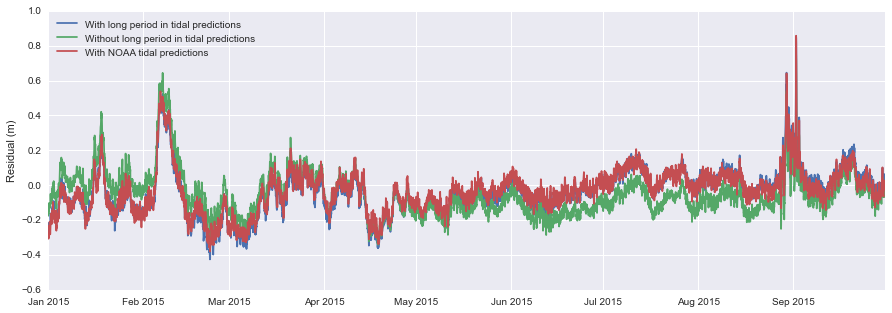

In [6]:
#plot
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(obs.time, res_long, label = 'With long period in tidal predictions')
ax.plot(obs.time, res_nolong, label = 'Without long period in tidal predictions')
ax.plot(obs.time, res_NOAA, label = 'With NOAA tidal predictions')
ax.legend(loc=0)
ax.set_ylabel('Residual (m)')

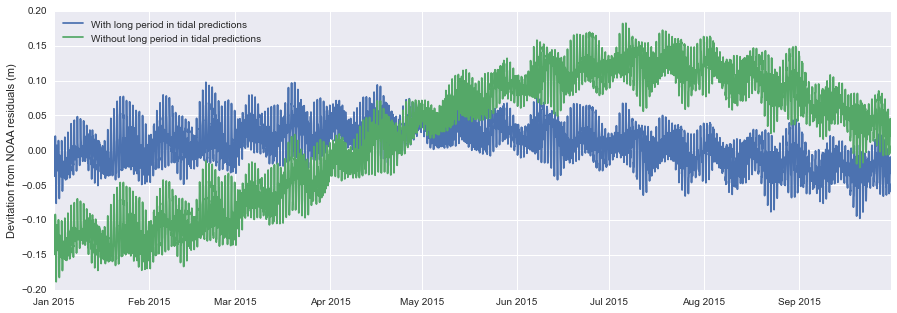

In [7]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(obs.time, res_NOAA - res_long, label = 'With long period in tidal predictions')
ax.plot(obs.time, res_NOAA - res_nolong, label = 'Without long period in tidal predictions')
ax.legend(loc=0)
ax.set_ylabel('Devitation from NOAA residuals (m)')

The NOAA residuals clearly match best with the tidal predictions with long period constituents. So, if we use NOAA to force the model, we are excluding the seasonal bits of the water level anomaly due to meteorlogical events.

I have analyzed three years of Neah Bay water levels, all of which had different amplitudes for Sa - 12cm, 8cm, and 10cm. I know this is small, but it is a pretty large fraction of the error in our nowcasts.

I also think this explains why, in October, the HYCOM anomaly is suddenly larger than NOAA (based on the cycle in the green line). But this idea doens't totally match with the fact that the summer HYCOM values are similar to NOAA (according to above, they should be smaller). 

There is a lot of short period variability (small amplitude) in the differnce. I blame any differences between harmonics I calculated and the ones that NOAA uses. 

## Moving forward
* If we want to keep using NOAA, I will generate my own tidal predictions (using NOAA constituents) but exclude the long period constituents. Then I will use the NOAA forcasted water level - my tidal predictions to calcaulte the anomaly.
* If we decide to go with HYCOM, then I won't worry about any of the above. A neat idea might be to experiment with HYCOM in the 3.6 runs.
* It would take more time/work to switch to HYCOM. I would need to do a fair amount of work setting up the netcdf files and testing before we can use this in the nowcast framework. 
* What does DFO do for its tidal predictions? We should keep this in mind when we compare our residauls.

We still have an issue with a semi-diurnal signal in our nowcast residuals. This was not present in the hindcasts. I think this signal is due to errors in the model tides. The hindcasts used an additional tidal simulation to calculate the residual, so any errors in the model tides were present in both the storm surge sim and the tidal sim. Now, we are using a separate tidal prediction meaning that any errors in the model tide will be expressed in the residual.